## Generating text for news headlines:
Language Modelling is the core problem for a number of of natural language processing tasks such as speech to text, conversational system, and text summarization. A trained language model learns the likelihood of occurrence of a word/ character based on the previous sequence of words/ characters used in the text. Language models can be operated at character level, n-gram level, sentence level or even paragraph level. We will create a language model for predicting next word by implementing and training state-of-the-art Recurrent Neural Networks under Deep Learning.

### 1. Import the libraries

In [1]:
# Let us import required libraries first
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils as ku
import tensorflow

# set seeds for reproducability
tensorflow.random.set_seed(200)

import pandas as pd
import numpy as np
import string

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'pandas'

### 2. Load the dataset

Load the dataset of news headlines

In [ ]:
!pip install opendatasets -q
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/manishguptads/news-headlines/code")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bawantharathnayake
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/manishguptads/news-headlines


100%|██████████| 243k/243k [00:00<00:00, 27.1MB/s]

In [ ]:
# news = pd.read_csv("/content/news-headlines/ArticlesMarch2018.csv")
# news.head()

In [ ]:
all_headlines = []
article_df = pd.read_csv('/content/news-headlines/ArticlesMarch2018.csv')
article_df.head()

,articleID,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL,articleWordCount
0,5a974697410cf7000162e8a4,By BINYAMIN APPELBAUM,article,"Virtual Coins, Real Resources","['Bitcoin (Currency)', 'Electric Light and Pow...",1,Business,1,01-03-2018 00:17,Economy,America has a productivity problem. One explan...,The New York Times,News,https://www.nytimes.com/2018/02/28/business/ec...,1207
1,5a974be7410cf7000162e8af,By HELENE COOPER and ERIC SCHMITT,article,U.S. Advances Military Plans for North Korea,"['United States Defense and Military Forces', ...",1,Washington,11,01-03-2018 00:40,Asia Pacific,The American military is looking at everything...,The New York Times,News,https://www.nytimes.com/2018/02/28/world/asia/...,1215
2,5a9752a2410cf7000162e8ba,By THE EDITORIAL BOARD,article,Mr. Trump and the ‘Very Bad Judge’,"['Trump, Donald J', 'Curiel, Gonzalo P', 'Unit...",1,Editorial,26,01-03-2018 01:08,Unknown,Can you guess which man is the model public se...,The New York Times,Editorial,https://www.nytimes.com/2018/02/28/opinion/tru...,1043
3,5a975310410cf7000162e8bd,By JAVIER C. HERNÁNDEZ,article,"To Erase Dissent, China Bans Pooh Bear and ‘N’","['China', 'Xi Jinping', 'Term Limits (Politica...",1,Foreign,1,01-03-2018 01:10,Asia Pacific,Censors swung into action after Mr. Xi’s bid t...,The New York Times,News,https://www.nytimes.com/2018/02/28/world/asia/...,1315
4,5a975406410cf7000162e8c3,"By JESSE DRUCKER, KATE KELLY and BEN PROTESS",article,Loans Flowed to Kushner Cos. After Visits to t...,"['Kushner, Jared', 'Kushner Cos', 'United Stat...",1,Business,1,01-03-2018 01:14,Unknown,"Apollo, the private equity firm, and Citigroup...",The New York Times,News,https://www.nytimes.com/2018/02/28/business/ja...,1566


In [ ]:
all_headlines.extend(list(article_df.headline.values))
all_headlines = [h for h in all_headlines if h != "Unknown"]
all_headlines[:10]

['Virtual Coins, Real Resources',
 'U.S. Advances Military Plans for North Korea',
 'Mr. Trump and the ‘Very Bad Judge’',
 'To Erase Dissent, China Bans Pooh Bear and ‘N’',
 'Loans Flowed to Kushner Cos. After Visits to the White House',
 'China Envoy Intends To Ease Trade Tensions',
 'President Trump’s Contradictory, and Sometimes False, Comments About Gun Policy to Lawmakers',
 'Classic Letter Puzzle',
 'Silicon Valley Disruption In an Australian School',
 '‘The Assassination of Gianni Versace’ Episode 6: A Nothing Man']

### 3. Dataset preparation

#### 3.1 Dataset cleaning

In dataset preparation step, we will first perform text cleaning of the data which includes removal of punctuations and lower casing all the words.

In [ ]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt

corpus = [clean_text(x) for x in all_headlines]
corpus[:10]

['virtual coins real resources',
 'us advances military plans for north korea',
 'mr trump and the very bad judge',
 'to erase dissent china bans pooh bear and n',
 'loans flowed to kushner cos after visits to the white house',
 'china envoy intends to ease trade tensions',
 'president trumps contradictory and sometimes false comments about gun policy to lawmakers',
 'classic letter puzzle',
 'silicon valley disruption in an australian school',
 'the assassination of gianni versace episode 6 a nothing man']

#### 3.2 Generating Sequence of N-gram Tokens
The next step is Tokenization. Tokenization is a process of extracting tokens (terms / words) from a corpus. Python’s library Keras has inbuilt model for tokenization which can be used to obtain the tokens and their index in the corpus. After this step, every text document in the dataset is converted into sequence of tokens.


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
token_list = tokenizer.texts_to_sequences(["I am happy to see you here today"])[0]
print(token_list)

check=[]

for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    check.append(n_gram_sequence)

check

[33, 469, 1062, 3, 191, 16, 84, 767]


[[33, 469],
 [33, 469, 1062],
 [33, 469, 1062, 3],
 [33, 469, 1062, 3, 191],
 [33, 469, 1062, 3, 191, 16],
 [33, 469, 1062, 3, 191, 16, 84],
 [33, 469, 1062, 3, 191, 16, 84, 767]]

In [ ]:
tokenizer.word_index

{'the': 1,
 'a': 2,
 'to': 3,
 'in': 4,
 'of': 5,
 'and': 6,
 'for': 7,
 'is': 8,
 'on': 9,
 'trump': 10,
 'with': 11,
 'at': 12,
 'what': 13,
 'how': 14,
 'it': 15,
 'you': 16,
 'new': 17,
 'from': 18,
 'as': 19,
 'trumps': 20,
 'an': 21,
 'be': 22,
 'its': 23,
 'trade': 24,
 'can': 25,
 'that': 26,
 'your': 27,
 'about': 28,
 'not': 29,
 'are': 30,
 'us': 31,
 'by': 32,
 'i': 33,
 'more': 34,
 'over': 35,
 'out': 36,
 'war': 37,
 'up': 38,
 'who': 39,
 'this': 40,
 'may': 41,
 'tariffs': 42,
 'gun': 43,
 'after': 44,
 'will': 45,
 'back': 46,
 'but': 47,
 'my': 48,
 'episode': 49,
 'was': 50,
 'says': 51,
 'do': 52,
 'season': 53,
 'why': 54,
 'now': 55,
 'president': 56,
 'no': 57,
 'or': 58,
 'we': 59,
 'when': 60,
 'north': 61,
 'one': 62,
 'teaching': 63,
 'get': 64,
 'into': 65,
 'house': 66,
 'black': 67,
 'her': 68,
 'have': 69,
 'korea': 70,
 'man': 71,
 'america': 72,
 'than': 73,
 'he': 74,
 'student': 75,
 'like': 76,
 'his': 77,
 'china': 78,
 'control': 79,
 'dont': 80,


In [ ]:
def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1

    ## convert data to sequence of tokens
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)

inp_sequences[:10], total_words

([[1119, 1120],
  [1119, 1120, 116],
  [1119, 1120, 116, 1121],
  [31, 1122],
  [31, 1122, 589],
  [31, 1122, 589, 392],
  [31, 1122, 589, 392, 7],
  [31, 1122, 589, 392, 7, 61],
  [31, 1122, 589, 392, 7, 61, 70],
  [117, 10]],
 3582)

In [ ]:
len(inp_sequences)

8057

In the above output [1119, 1120], [1119, 1120,116], [1119, 1120, 116, 1121] and so on represents the ngram phrases generated from the input data. where every integer corresponds to the index of a particular word in the complete vocabulary of words present in the text. For example

**Headline:** i stand  with the shedevils  
**Ngrams:** | **Sequence of Tokens**

<table>
<tr><td>Ngram </td><td> Sequence of Tokens</td></tr>
<tr> <td>i stand </td><td> [30, 507] </td></tr>
<tr> <td>i stand with </td><td> [30, 507, 11] </td></tr>
<tr> <td>i stand with the </td><td> [30, 507, 11, 1] </td></tr>
<tr> <td>i stand with the shedevils </td><td> [30, 507, 11, 1, 975] </td></tr>
</table>



#### 3.3 Padding the Sequences and obtain Variables : Predictors and Target
Now we have generated a data-set which contains sequence of tokens. Before starting training the model, we need to pad the sequences and make their lengths equal. We can use pad_sequence function of Kears for this purpose. To input this data into a learning model, we need to create predictors and label. For example:


Headline:  they are learning data science

<table>
<tr><td>PREDICTORS </td> <td>           LABEL </td></tr>
<tr><td>they                   </td> <td>  are</td></tr>
<tr><td>they are               </td> <td>  learning</td></tr>
<tr><td>they are learning      </td> <td>  data</td></tr>
<tr><td>they are learning data </td> <td>  science</td></tr>
</table>

In [ ]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)
predictors,label,len(label[0]),max_sequence_len

(array([[   0,    0,    0, ...,    0,    0, 1119],
        [   0,    0,    0, ...,    0, 1119, 1120],
        [   0,    0,    0, ..., 1119, 1120,  116],
        ...,
        [   0,    0,    0, ...,  979,  151,  386],
        [   0,    0,    0, ...,    0,    0, 3581],
        [   0,    0,    0, ...,    0, 3581,    5]], dtype=int32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 3582,
 18)

Labels are one-hot encoded into a 1d array of same length as the total number of words,
so that the output of softmax layer of the model can directly be compared with label without any further processing

In [ ]:
print(label[0])
print(label[0].shape)

[0. 0. 0. ... 0. 0. 0.]
(3582,)


Perfect, now we can obtain the input vector X (predictors) and the label vector Y (label) which can be used for the training purposes. Now we will create RNN model for out data.

### 4. RNN for Text Generation
Unlike Feed-forward neural networks in which activation outputs are propagated only in one direction, the activation outputs from neurons propagate in both directions (from inputs to outputs and from outputs to inputs) in Recurrent Neural Networks. This creates loops in the neural network architecture which acts as a ‘memory state’ of the neurons. This state allows the neurons an ability to remember what have been learned so far.

The memory state in RNNs gives an advantage over traditional neural networks. Lets architecture a RNN model in our code. We have added total three layers in the model.

1. Input Layer : Takes the sequence of words as input
2. RNN Layer : Computes the output using RNN units. We have added 200 units in the layer.
3. Dropout Layer : A regularisation layer which randomly turns-off the activations of some neurons in the RNN layer. It helps in preventing over fitting.
4. Output Layer : Computes the probability of the best possible next word as output

We will run this model for total 100 epoochs but it can be experimented further.

In [ ]:
def create_model(max_sequence_len, total_words):
    ## after being converted into X and Y, one words is removed from the input and output sequences
    input_len = max_sequence_len - 1

    model = Sequential()

    # Setting early_stopping feature to stop early on getting stagnant
    early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    # Add Input Embedding Layer
    model.add(Embedding(total_words, 32, input_length=input_len))

    # input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
    # output_dim: Integer. Dimension of the dense embedding.
    # input_length: Length of input sequences, when it is constant.

    # Add Hidden Layer 1 - RNN Layer
    # 100 units in the hidden layer
    model.add(SimpleRNN(100))

    # Add Hidden Layer 2 - Dropout Layer
    # To avoid overfitting

    model.add(Dropout(0.1))

    # Add Output Layer
    model.add(Dense(units=total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 32)            114624    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               13300     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 3582)              361782    
                                                                 
Total params: 489706 (1.87 MB)
Trainable params: 489706 (1.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


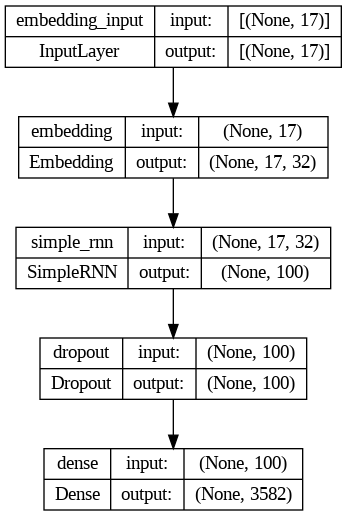

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.fit(predictors, label, epochs=100)

Epoch 1/100
252/252 [==============================] - 10s 31ms/step - loss: 7.6083
Epoch 2/100
252/252 [==============================] - 6s 25ms/step - loss: 7.0522
Epoch 3/100
252/252 [==============================] - 4s 15ms/step - loss: 6.7535
Epoch 4/100
252/252 [==============================] - 5s 20ms/step - loss: 6.4222
Epoch 5/100
252/252 [==============================] - 4s 14ms/step - loss: 6.0830
Epoch 6/100
252/252 [==============================] - 3s 14ms/step - loss: 5.7649
Epoch 7/100
252/252 [==============================] - 5s 19ms/step - loss: 5.4554
Epoch 8/100
252/252 [==============================] - 4s 14ms/step - loss: 5.1527
Epoch 9/100
252/252 [==============================] - 3s 14ms/step - loss: 4.8611
Epoch 10/100
252/252 [==============================] - 4s 15ms/step - loss: 4.5614
Epoch 11/100
252/252 [==============================] - 5s 18ms/step - loss: 4.2766
Epoch 12/100
252/252 [==============================] - 3s 14ms/step - loss: 4.0047


In [ ]:
model.save("next_word_prediction_model_news_headline_grp33.h5")

In [ ]:
model.save("next_word_prediction_model_news_headline_grp33.keras")

In [ ]:
model_loaded = tensorflow.keras.models.load_model('next_word_prediction_model_news_headline_grp33.keras')

## 5. Generating the text

Great, our model architecture is now ready and we can train it using our data. Next lets write the function to predict the next word based on the input words (or seed text). We will first tokenize the seed text, pad the sequences and pass into the trained model to get predicted word. The multiple predicted words can be appended together to get predicted sequence.


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model

def generate_text(seed_text, next_words, model, tokenizer, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        predicted_probs = model.predict(token_list, verbose=False)
        predicted = np.argmax(predicted_probs, axis=-1)[0]

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text.title()



print(generate_text("Loans", 25, model, tokenizer, max_sequence_len))
# print(generate_text("president trump", 15, model, tokenizer, max_sequence_len))
# print(generate_text("donald", 6, model, tokenizer, max_sequence_len))
# print(generate_text("india and china", 2, model, tokenizer, max_sequence_len))
# print(generate_text("new york", 4, model, tokenizer, max_sequence_len))
# print(generate_text("science and technology", 6, model, tokenizer, max_sequence_len))


Loans Flowed To Kushner Cos After Visits To The White House Stays In The White House Stays In The White House Stays In The White House


## 6. Tests

In [ ]:
max_sequence_len = max([len(input_sequence) for input_sequence in inp_sequences])
max_sequence_len

18

In [ ]:
tokenizer_json = tokenizer.to_json()
with open('tokenizer_news_headline_grp33.json', 'w') as file:
    file.write(tokenizer_json)

In [ ]:
!pip install keras tensorflow